In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection

In [3]:
import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [4]:
%matplotlib inline

In [5]:
from jupyterthemes import jtplot
jtplot.style()

In [5]:
def train_models(x_train, x_test, y_train, y_test, models, run_label):
    predicts = pd.DataFrame([])
    scores = pd.DataFrame([])
    for name, model in models:
        print('Training model:', name)
        t0 = time.time()
        model.fit(x_train.values, y_train.values.ravel())    
        predict = (
            pd.DataFrame({
                    'predict': model.predict(x_test), 
                    'predict_proba': model.predict_proba(x_test)[:,1]
                })
              .assign(actual = y_test.values)
              .assign(model = name)
              .assign(run = run_label)
              .reindex(['run', 'model', 'actual', 'predict', 'predict_proba'], axis=1)
        )        
        score = {
            'model': name,
            'run': run_label,
            'precision': metrics.precision_score(predict['actual'], predict['predict']),
            'recall': metrics.recall_score(predict['actual'], predict['predict']),
            'ap_score': metrics.average_precision_score(predict['actual'], predict['predict']),
            'f1_score': metrics.f1_score(predict['actual'], predict['predict']),
            'roc_auc_score': metrics.roc_auc_score(predict['actual'], predict['predict']),
        }
        predicts = predicts.append(predict, ignore_index=False, sort=False)
        scores = (scores
                    .append([score])
                    .reindex(['run', 'model', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'ap_score'], axis=1)
                 )
                  
        t1 = time.time()
        print('done in %0.1f seconds\n' % float(t1-t0))
        
    return predicts, scores, models
    

In [73]:
def plot_curve(predicts, scores, curve='PR', proba=True, title=None):
    fig, ax = plt.subplots()
    for name in scores.model.sort_values().unique():
        predict = predicts[predicts.model == name]
        score = scores[scores.model == name]
        if not proba:
            pr = predict.predict
        else:
            pr = predict.predict_proba
        if curve=='PR':
            yval, xval, _ = metrics.precision_recall_curve(predict.actual, pr)
            xlabel = 'Recall'
            ylabel = 'precision'
        elif curve=='ROC':    
            xval, yval, _ = metrics.roc_curve(predict.actual, pr)
            xlabel = 'FP rate'
            ylabel = 'TP rate'
        ap_score = score.ap_score.unique().max()
        curve_label = '{} - AP score={:.5f}'.format(name, ap_score)
        sns.lineplot(x=xval, y=yval, palette='dark', label=curve_label, ax=ax)
    if not title:
        title = curve + ' curves for models\n'
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()    
    return 
    
    

In [7]:
def plot_matrix(predicts, scores):
    rows = int(np.ceil(scores.model.nunique()/3))
    cols = 3
    fig, axes = plt.subplots(rows,cols, figsize=(cols*4,rows*4), sharex=False)
    axes = axes.flatten()

    for ax, name in zip(axes, scores.sort_values('ap_score', ascending=False).model.unique()):
        predict = predicts[predicts.model == name]
        score = scores[scores.model == name]
        ap_score = score.ap_score.unique().max()
        plot_label = '{} - AP score={:.5f}'.format(name, ap_score)
        cm = metrics.confusion_matrix(predict.actual, predict.predict)
        sns.heatmap(cm, 
                    annot=True, fmt='d', square=True, 
                    cbar_kws={'shrink': 0.5},
                    annot_kws={'fontsize':16},
                
                    ax=ax)
        ax.set_title(plot_label + '\n')
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')

    plt.subplots_adjust(hspace=.8, wspace=0.8)                 
    plt.show()
    return
        

# The Data

### Reading the file

In [85]:
fr = pd.read_csv('creditcard.csv').rename(columns=lambda x: x.lower())

In [86]:
fr.index.size

284807

In [87]:
fr.sample(5)

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
228315,145458.0,1.990235,-1.095310,-0.903916,-0.482769,-0.843030,-0.278783,-0.719501,-0.011988,-0.307537,...,-0.302081,-0.445502,0.195144,-0.482045,-0.413854,0.564439,-0.049319,-0.056339,74.20,0
238705,149785.0,-2.891481,1.658956,0.609894,-0.559404,-0.415737,1.168819,-0.852167,0.676160,0.281529,...,0.689386,-0.400487,0.118937,-1.077871,0.245232,-0.349835,-0.422365,-0.195562,14.43,0
93756,64574.0,1.205206,1.276373,-1.558861,1.527683,0.926461,-1.497423,0.697271,-0.259550,-0.759554,...,-0.154825,-0.364341,-0.225317,0.014051,0.839589,-0.312732,0.038440,0.087522,1.00,0
149449,91257.0,1.924344,-0.141902,-1.350975,0.434101,0.209169,-0.783637,0.167376,-0.354528,1.590594,...,0.170270,0.731517,-0.104341,-0.347955,0.242600,-0.155200,-0.061569,-0.065884,70.18,0
176124,122635.0,-6.261365,5.812087,-4.508429,-0.674773,-0.983810,2.944316,-8.787143,-19.970445,-2.723794,...,-9.755161,3.843369,1.465544,0.414553,-0.389210,0.363698,-1.471886,-0.213290,0.76,0


In [88]:
fr.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class'],
      dtype='object')

### What't inside the dataset?

In [89]:
fr.assign(percent = 100/fr.index.size).groupby('class').percent.agg(['count', 'sum']).rename(columns={'sum': '%'})

,count,%
class,,
0,284315,99.827251
1,492,0.172749


In [90]:
fr.describe().T

,count,mean,std,min,25%,50%,75%,max
time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
v1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
v2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
v3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
v4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
v5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
v6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
v7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
v8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
v9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


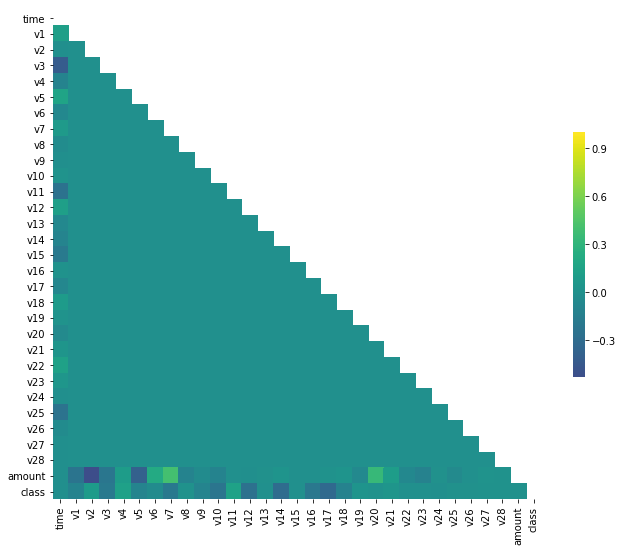

In [91]:
corr = fr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(fr.corr(), mask=mask, cmap='viridis', center=0, square=True, cbar_kws={"shrink": .5})
plt.show()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FAA97A4358>,
      dtype=object)

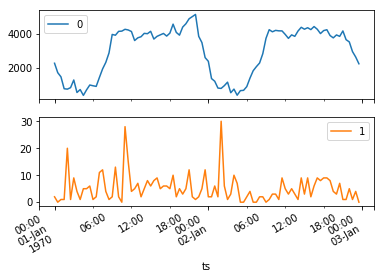

In [92]:
(fr.assign(ts = pd.to_datetime(fr.time*1e9))[['ts', 'class']]
   .groupby(['ts', 'class']).size()   
   .unstack()
   .resample('30min').sum()   
).plot(subplots=True)

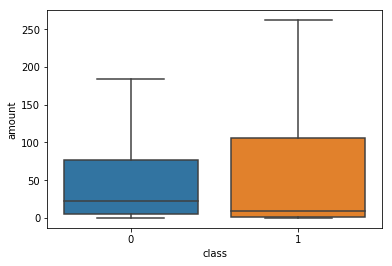

In [93]:
sns.boxplot(data=fr, x='class', y='amount', showfliers=False) #[['amount', 'class']])

In [94]:
fr.groupby('class').amount.describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


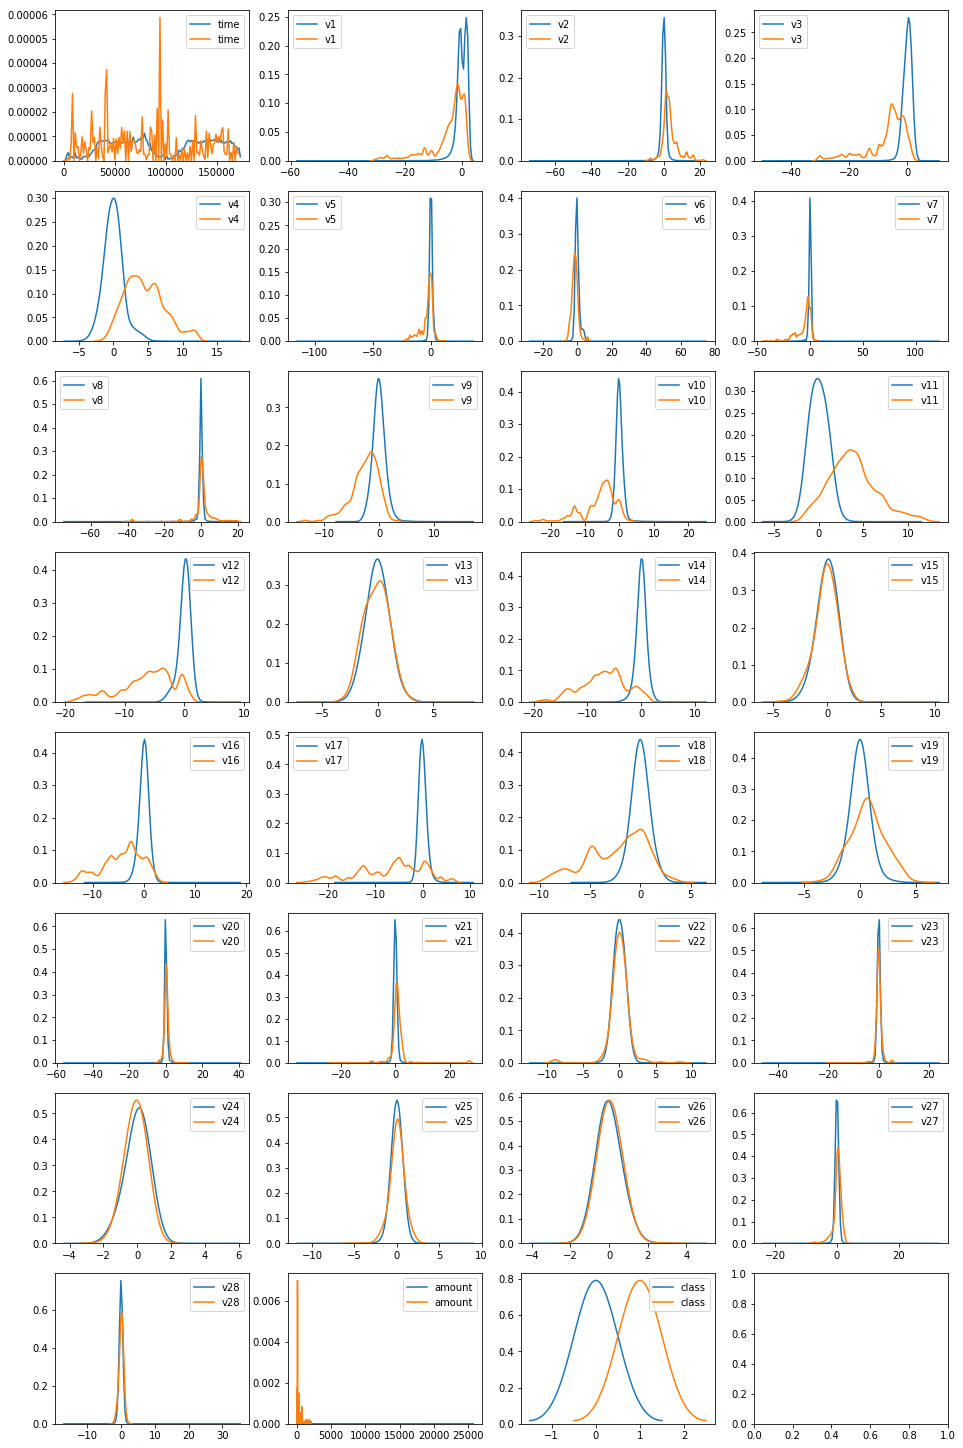

In [95]:
fig, ax = plt.subplots(int(np.ceil(fr.columns.size/4)),4, figsize=(16,26))
ax = ax.flatten()
for i, feature in enumerate(fr.columns.values):
    sns.kdeplot(fr[fr['class']==0][feature], bw=0.5, ax=ax[i])    
    sns.kdeplot(fr[fr['class']==1][feature], bw=0.5, ax=ax[i])
plt.show()    
    

### Creating train/test split

In [96]:
x_cols = [
    'time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
    'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
    'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount'
]

In [97]:
y_cols = ['class']

In [98]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fr[x_cols], fr[y_cols],
    test_size=0.2, random_state=45
)

In [99]:
for s in (x_train, x_test, y_train, y_test):
    print(s.shape)

(227845, 30)
(56962, 30)
(227845, 1)
(56962, 1)


# Quality Metrics

In [100]:
two_models = [
    ('LR', LogisticRegression()),    
    ('LDA', LinearDiscriminantAnalysis()),
    
]    

In [101]:
run_predicts, run_scores, _ = train_models(x_train, x_test, y_train, y_test, two_models, 'two')

Training model: LR
done in 10.2 seconds

Training model: LDA
done in 1.3 seconds



In [102]:
run_scores

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,two,LR,0.876543,0.617391,0.724490,0.808608,0.541943
0,two,LDA,0.921569,0.817391,0.866359,0.908625,0.753651


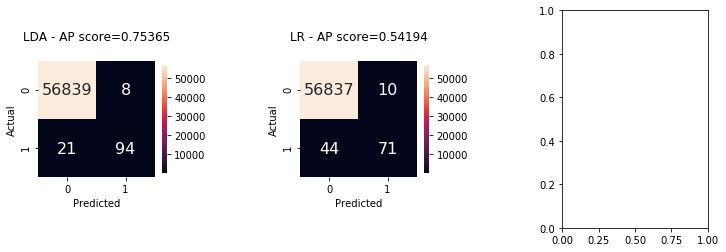

In [103]:
plot_matrix(run_predicts, run_scores)

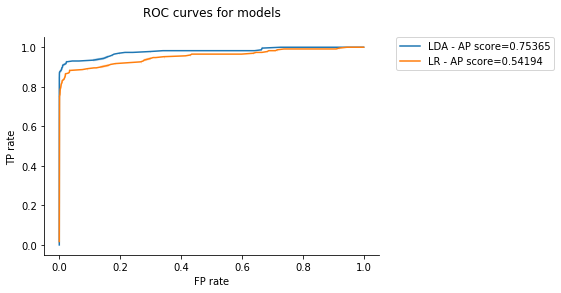

In [104]:
plot_curve(run_predicts, run_scores, curve='ROC')

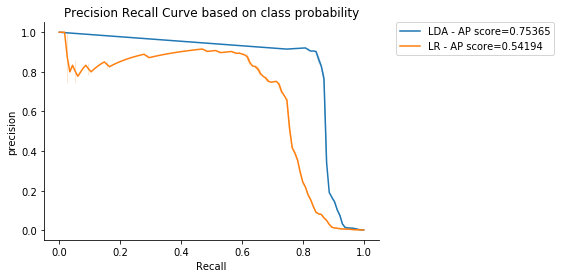

In [105]:
plot_curve(run_predicts, run_scores, curve='PR', title='Precision Recall Curve based on class probability')

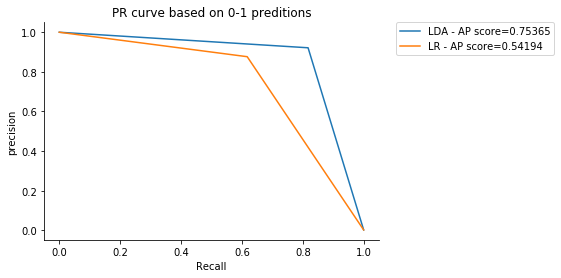

In [106]:
plot_curve(run_predicts, run_scores, curve='PR', proba=False, title="PR curve based on 0-1 preditions")

# Training the Models

## Basic

In [30]:
basic_models = [
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('RF', RandomForestClassifier()),
    ('LGBM', lgb.LGBMClassifier())
#    ('SVM', SVC())
]

In [31]:
predicts = pd.DataFrame([])
scores = pd.DataFrame([])

In [32]:
run_predicts, run_scores, run_models = train_models(x_train, x_test, y_train, y_test, basic_models, 'basic')

predicts = predicts.append(run_predicts)
scores = scores.append(run_scores)

Training model: LR
done in 5.2 seconds

Training model: LDA
done in 0.9 seconds

Training model: KNN
done in 5.6 seconds

Training model: RF
done in 30.7 seconds

Training model: LGBM


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


done in 4.1 seconds



In [33]:
predicts.to_pickle('predicts_1.pkl')
scores.to_pickle('scores_1.pkl')

In [107]:
scores.query("run == 'basic'").sort_values('ap_score', ascending=False)

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,basic,RF,0.978261,0.782609,0.869565,0.891287,0.766034
0,basic,LDA,0.921569,0.817391,0.866359,0.908625,0.753651
0,basic,LR,0.876543,0.617391,0.724490,0.808608,0.541943
0,basic,LGBM,0.587719,0.582609,0.585153,0.790891,0.343253
0,basic,KNN,1.000000,0.069565,0.130081,0.534783,0.071444


In [108]:
predicts.sample(10)

,run,model,actual,predict,predict_proba
51546,rf_tunung,RF-10,0,0,0.000000
14398,feature_selection,KNN,0,0,0.000000
44278,class_balancing,RF-1,0,0,0.000000
10711,class_balancing,RF-100,0,0,0.000000
56059,basic,RF,0,0,0.000000
52422,rf_tunung,RF-150,0,0,0.006667
8501,scaling,RF,0,0,0.000000
13453,class_balancing,LGBM-100,0,0,0.000598
53774,scaling,LR,0,0,0.000008
26792,feature_selection,LR,0,0,0.000298


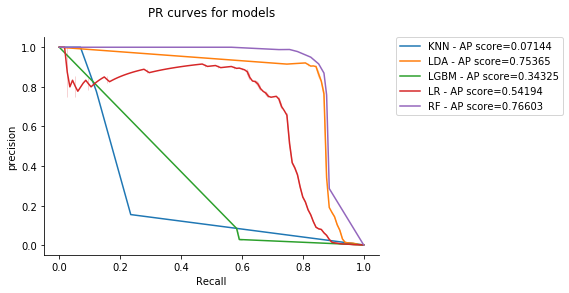

In [109]:
plot_curve(predicts.query("run == 'basic'"), scores.query("run == 'basic'"))

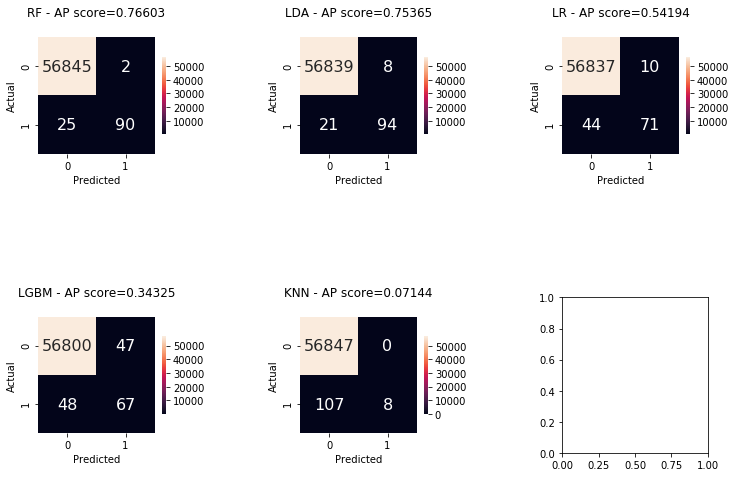

In [110]:
plot_matrix(predicts.query("run == 'basic'"), scores.query("run == 'basic'"))

## Making It Better

### 1. Scaling Features

In [38]:
fr[x_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
v1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
v2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
v3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
v4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
v5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
v6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
v7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
v8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
v9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [39]:
scale = StandardScaler()

In [40]:
fr[x_cols] = scale.fit_transform(fr[x_cols])


In [41]:
fr.describe().T

,count,mean,std,min,25%,50%,75%,max
time,284807.0,-1.050379e-14,1.000002,-1.996583,-0.855212,-0.213145,0.937217,1.642058
v1,284807.0,-8.157366e-16,1.000002,-28.798555,-0.469892,0.009245,0.671694,1.253351
v2,284807.0,3.154853e-17,1.000002,-44.035292,-0.362471,0.039657,0.486720,13.357750
v3,284807.0,-4.409878e-15,1.000002,-31.871733,-0.587214,0.118612,0.677457,6.187993
v4,284807.0,-6.734811e-16,1.000002,-4.013919,-0.599379,-0.014017,0.525008,11.918743
v5,284807.0,-2.874435e-16,1.000002,-82.408097,-0.501069,-0.039367,0.443346,25.214135
v6,284807.0,4.168992e-16,1.000002,-19.636058,-0.576682,-0.205805,0.299163,55.020149
v7,284807.0,-8.767997e-16,1.000002,-35.209396,-0.447886,0.032417,0.461111,97.478239
v8,284807.0,-2.423604e-16,1.000002,-61.302524,-0.174680,0.018720,0.274078,16.751534
v9,284807.0,3.078727e-16,1.000002,-12.228015,-0.585363,-0.046812,0.543531,14.194945


In [42]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fr[x_cols], fr[y_cols],
    test_size=0.2, random_state=45
)

In [43]:
cs_models = [
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('RF', RandomForestClassifier()),
    ('LGBM', lgb.LGBMClassifier())
]    


In [44]:
run_predicts, run_scores, run_models = train_models(x_train, x_test, y_train, y_test, cs_models, 'scaling')

predicts = predicts.append(run_predicts)
scores = scores.append(run_scores)

Training model: LR
done in 4.2 seconds

Training model: LDA
done in 0.9 seconds

Training model: RF
done in 26.3 seconds

Training model: LGBM


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


done in 3.8 seconds



In [79]:
scores.query("run == 'scaling'")

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,scaling,LR,0.925000,0.643478,0.758974,0.821686,0.595937
0,scaling,LDA,0.921569,0.817391,0.866359,0.908625,0.753651
0,scaling,RF,0.978022,0.773913,0.864078,0.886939,0.757360
0,scaling,LGBM,0.281553,0.504348,0.361371,0.750872,0.143002


In [46]:
scores.sort_values('ap_score', ascending=False)

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,basic,RF,0.978261,0.782609,0.869565,0.891287,0.766034
0,scaling,RF,0.978022,0.773913,0.864078,0.886939,0.757360
0,basic,LDA,0.921569,0.817391,0.866359,0.908625,0.753651
0,scaling,LDA,0.921569,0.817391,0.866359,0.908625,0.753651
0,scaling,LR,0.925000,0.643478,0.758974,0.821686,0.595937
0,basic,LR,0.876543,0.617391,0.724490,0.808608,0.541943
0,basic,LGBM,0.587719,0.582609,0.585153,0.790891,0.343253
0,scaling,LGBM,0.281553,0.504348,0.361371,0.750872,0.143002
0,basic,KNN,1.000000,0.069565,0.130081,0.534783,0.071444


### 2. Feature Selection

In [48]:
fr_model = run_models[2][1]

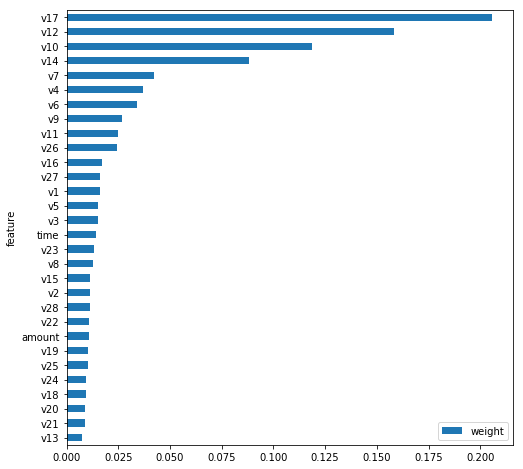

In [111]:
(pd.DataFrame({'feature': x_cols, 'weight': fr_model.feature_importances_})
 .set_index('feature')
 .sort_values('weight')
 .plot(kind='barh', figsize=(8,8))
) 


In [112]:
best_features = (pd.DataFrame({'feature': x_cols, 'weight': fr_model.feature_importances_})
 .set_index('feature')
 .sort_values('weight')
 .tail(8)
).index.values


In [113]:
best_features

array(['v9', 'v6', 'v4', 'v7', 'v14', 'v10', 'v12', 'v17'], dtype=object)

In [52]:
run_predicts, run_scores, run_models = train_models(
    x_train[best_features], x_test[best_features], y_train, y_test, 
    basic_models, 'feature_selection')

predicts = predicts.append(run_predicts)
scores = scores.append(run_scores)

Training model: LR
done in 0.7 seconds

Training model: LDA
done in 0.2 seconds

Training model: KNN
done in 45.2 seconds

Training model: RF
done in 11.3 seconds

Training model: LGBM


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


done in 2.2 seconds



In [53]:
run_scores

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,feature_selection,LR,0.929577,0.573913,0.709677,0.786913,0.534357
0,feature_selection,LDA,0.869159,0.808696,0.837838,0.904225,0.703271
0,feature_selection,KNN,0.941176,0.834783,0.884793,0.917339,0.786011
0,feature_selection,RF,0.967033,0.765217,0.854369,0.882582,0.740464
0,feature_selection,LGBM,0.156805,0.460870,0.233996,0.727928,0.073355


In [54]:
scores.sort_values('ap_score', ascending=False)

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,feature_selection,KNN,0.941176,0.834783,0.884793,0.917339,0.786011
0,basic,RF,0.978261,0.782609,0.869565,0.891287,0.766034
0,scaling,RF,0.978022,0.773913,0.864078,0.886939,0.757360
0,basic,LDA,0.921569,0.817391,0.866359,0.908625,0.753651
0,scaling,LDA,0.921569,0.817391,0.866359,0.908625,0.753651
0,feature_selection,RF,0.967033,0.765217,0.854369,0.882582,0.740464
0,feature_selection,LDA,0.869159,0.808696,0.837838,0.904225,0.703271
0,scaling,LR,0.925000,0.643478,0.758974,0.821686,0.595937
0,basic,LR,0.876543,0.617391,0.724490,0.808608,0.541943
0,feature_selection,LR,0.929577,0.573913,0.709677,0.786913,0.534357


### Balancing Class Sizes

In [57]:
fr.groupby('class').size()

class
0    284315
1       492
dtype: int64

In [58]:
weighted_models = [
    ('LR-1', LogisticRegression()),
    ('LR-10', LogisticRegression(class_weight={1:10})),
    ('LR-100', LogisticRegression(class_weight={1:100})),
    ('RF-1', RandomForestClassifier()),
    ('RF-10', RandomForestClassifier(class_weight={1:10})),
    ('RF-100', RandomForestClassifier(class_weight={1:100})),
    ('LGBM-1', lgb.LGBMClassifier()),
    ('LGBM-10', lgb.LGBMClassifier(class_weight={1:10})),
    ('LGBM-100', lgb.LGBMClassifier(class_weight={1:100}))
]

In [59]:
run_predicts, run_scores, run_models = train_models(
    x_train[best_features], x_test[best_features], y_train, y_test, 
    weighted_models, 'class_balancing')

predicts = predicts.append(run_predicts)
scores = scores.append(run_scores)

Training model: LR-1
done in 0.7 seconds

Training model: LR-10
done in 0.8 seconds

Training model: LR-100
done in 1.4 seconds

Training model: RF-1
done in 12.5 seconds

Training model: RF-10
done in 12.7 seconds

Training model: RF-100
done in 10.0 seconds

Training model: LGBM-1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


done in 3.8 seconds

Training model: LGBM-10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


done in 5.0 seconds

Training model: LGBM-100


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


done in 4.5 seconds



In [60]:
run_scores

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,class_balancing,LR-1,0.929577,0.573913,0.709677,0.786913,0.534357
0,class_balancing,LR-10,0.706767,0.817391,0.758065,0.908353,0.578074
0,class_balancing,LR-100,0.341297,0.869565,0.490196,0.933085,0.297043
0,class_balancing,RF-1,0.957447,0.782609,0.861244,0.891269,0.749745
0,class_balancing,RF-10,0.978723,0.800000,0.880383,0.899982,0.783383
0,class_balancing,RF-100,0.965909,0.739130,0.837438,0.869539,0.714459
0,class_balancing,LGBM-1,0.156805,0.460870,0.233996,0.727928,0.073355
0,class_balancing,LGBM-10,0.855856,0.826087,0.840708,0.912903,0.707362
0,class_balancing,LGBM-100,0.750000,0.834783,0.790123,0.917110,0.626421


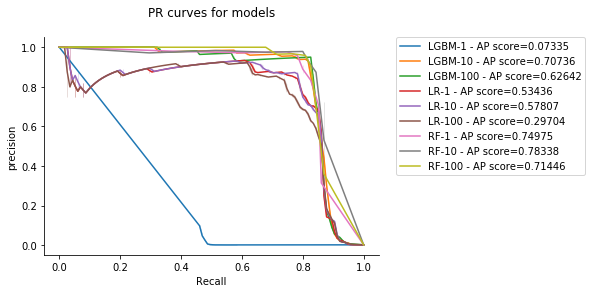

In [114]:
plot_curve(predicts.query("run == 'class_balancing'"), scores.query("run == 'class_balancing'"))

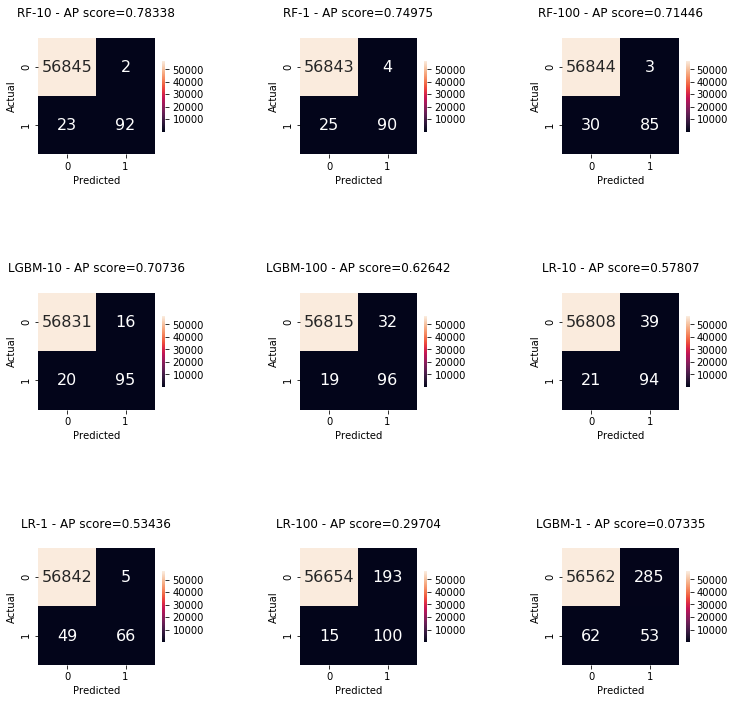

In [115]:
plot_matrix(predicts.query("run == 'class_balancing'"), scores.query("run == 'class_balancing'"))

In [116]:
scores.sort_values('ap_score', ascending=False).head(5)

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,feature_selection,KNN,0.941176,0.834783,0.884793,0.917339,0.786011
0,class_balancing,RF-10,0.978723,0.800000,0.880383,0.899982,0.783383
0,rf_tunung,RF-150,0.968421,0.800000,0.876190,0.899974,0.775141
0,rf_tunung,RF-50,0.968085,0.791304,0.870813,0.895626,0.766471
0,rf_tunung,RF-10,0.968085,0.791304,0.870813,0.895626,0.766471


### Model Params Tuning

In [67]:
tuned_rf_models = [
    ('RF-10', RandomForestClassifier(n_estimators=10)),
    ('RF-20', RandomForestClassifier(n_estimators=20)),
    ('RF-50', RandomForestClassifier(n_estimators=50)),    
    ('RF-150', RandomForestClassifier(n_estimators=150))    
]


In [68]:
run_predicts, run_scores, run_models = train_models(
    x_train[best_features], x_test[best_features], y_train, y_test, 
    tuned_rf_models, 'rf_tunung')

predicts = predicts.append(run_predicts)
scores = scores.append(run_scores)

Training model: RF-10
done in 10.2 seconds

Training model: RF-20
done in 20.8 seconds

Training model: RF-50
done in 57.7 seconds

Training model: RF-150
done in 170.2 seconds



In [71]:
predicts.to_pickle('predicts_all.pkl')
scores.to_pickle('scores_all.pkl')

In [69]:
run_scores

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,rf_tunung,RF-10,0.968085,0.791304,0.870813,0.895626,0.766471
0,rf_tunung,RF-20,0.955056,0.739130,0.833333,0.869530,0.706438
0,rf_tunung,RF-50,0.968085,0.791304,0.870813,0.895626,0.766471
0,rf_tunung,RF-150,0.968421,0.800000,0.876190,0.899974,0.775141


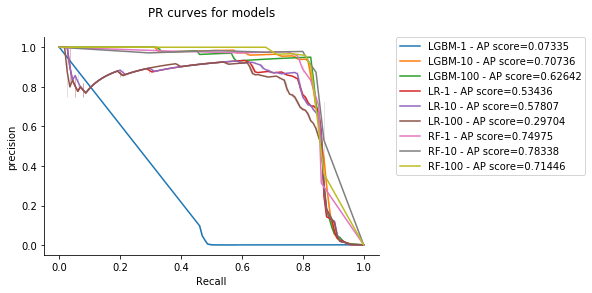

In [117]:
plot_curve(predicts.query("run == 'class_balancing'"), scores.query("run == 'class_balancing'"))

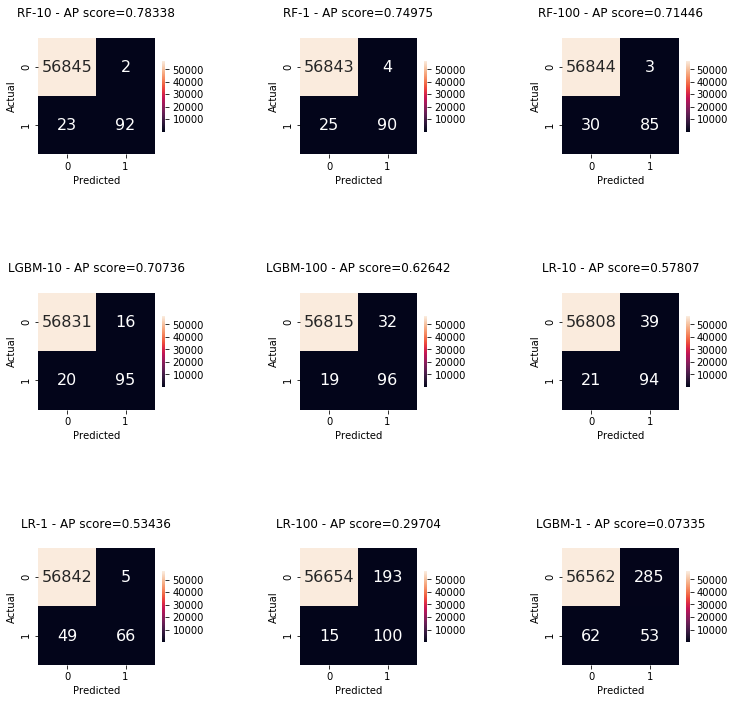

In [118]:
plot_matrix(predicts.query("run == 'class_balancing'"), scores.query("run == 'class_balancing'"))

### Final Score

In [119]:
scores.sort_values('ap_score', ascending=False).head(10)

,run,model,precision,recall,f1_score,roc_auc_score,ap_score
0,feature_selection,KNN,0.941176,0.834783,0.884793,0.917339,0.786011
0,class_balancing,RF-10,0.978723,0.800000,0.880383,0.899982,0.783383
0,rf_tunung,RF-150,0.968421,0.800000,0.876190,0.899974,0.775141
0,rf_tunung,RF-50,0.968085,0.791304,0.870813,0.895626,0.766471
0,rf_tunung,RF-10,0.968085,0.791304,0.870813,0.895626,0.766471
0,basic,RF,0.978261,0.782609,0.869565,0.891287,0.766034
0,scaling,RF,0.978022,0.773913,0.864078,0.886939,0.757360
0,basic,LDA,0.921569,0.817391,0.866359,0.908625,0.753651
0,scaling,LDA,0.921569,0.817391,0.866359,0.908625,0.753651
0,class_balancing,RF-1,0.957447,0.782609,0.861244,0.891269,0.749745
